In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim
import cv2 as cv
from IPython import display

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
dat = np.load('Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = dat['listgal'][0,:,:]
psf = galsim.Image(img1, copy=True).array

psf /= np.sum(psf)

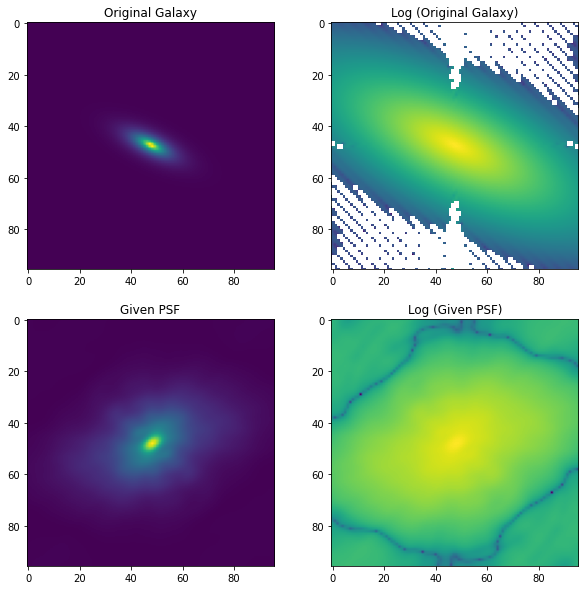

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal); ax1.set_title('Original Galaxy');
ax2.imshow(np.log10(gal)); ax2.set_title('Log (Original Galaxy)');
ax3.imshow(psf); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf)); ax4.set_title('Log (Given PSF)');

### FFT(Galaxy) + Gaussian Noise

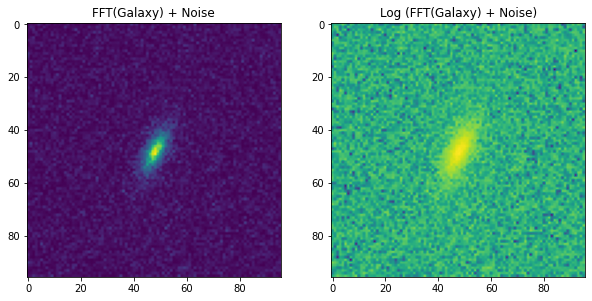

In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                                       # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(np.abs(gal_fft_GSO.array)); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(np.abs(gal_fft_GSO.array))); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

(0.06832032443786301, 0.06832032443786301)

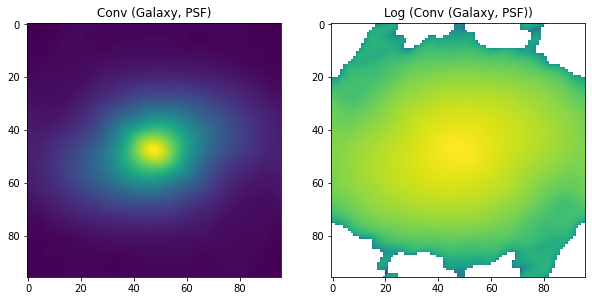

In [8]:
conv = np.multiply(gal_fft_GSO.array, psf_fft)

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))  # IFFT to get back to brightness domain
final_gal = final_gal * (np.sum(gal)/np.sum(final_gal))                     # Normalisation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

np.sum(gal), np.sum(final_gal)

# ADMM

In [9]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def l1_norm(signal):

    return np.sum(np.abs(signal))


def sigma_mad(signal):

    return 1.4826 * np.median(np.abs(signal - np.median(signal)))


def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))


def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold /
                     np.maximum(np.finfo(np.float64).eps,
                                np.abs(data))), 0.0) * data,
                     decimals=15)


def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [10]:
# Projection - Enforce non-negative values
def proj(xi):
    
    xi = np.maximum(xi,0)
    return xi


def grad_desc(x_rec, alpha, observation, psf, ST_lambda):
    
    xk = x_rec - alpha*grad(observation, x_rec, psf)
    x_rec = soft_thresh(xk, ST_lambda)
    return x_rec
   
 
def FISTA(tk, xk, x_rec, alpha, observation, psf, ST_lambda):

    x_k1 = xk
    x_temp = x_rec - alpha*grad(observation, x_rec, psf)
    x_temp = soft_thresh(x_temp, ST_lambda)
    xk = proj(x_temp)
    t_k1 = (1 + np.sqrt(1 + 4*tk**2))/2
    x_rec = xk + (tk - 1)/t_k1*(xk - x_k1)
    tk = t_k1
    return x_rec, tk, xk


""" 
def FISTA(xk, z_fista_old, z_k, tk, mu_k, alpha, observation, psf, ST_lambda, rho, sigma=1.0):    
    
    x_fista_new = z_fista_old - alpha * (grad(observation, z_fista_old, psf) + mu_k * sigma**2 + rho*sigma**2 * (z_fista_old - z_k))
    x_fista_new = soft_thresh(x_fista_new, ST_lambda)
    x_fista_new = proj(x_fista_new)
    
    t_k1 = (1. + np.sqrt(4. * tk**2 + 1.))/2.
    lambda_fista = 1 + (tk - 1)/t_k1
    z_fista_new = xk + lambda_fista * (x_fista_new - xk)

    z_fista_old = z_fista_new
    tk = t_k1
    
    return x_fista_new, tk, xk
"""


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))


# The gradient
def grad(y, x_rec, psf):

    return ifft(Ht(H(fft(x_rec), psf) - y, psf))


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, reg_lambda, var=1.0):

    cost_val = 0.5*rho*np.linalg.norm(z-x_rec)**2 - np.dot(mu.flatten(),(z-x_rec).flatten()) + (0.5/var)*np.linalg.norm(y - H(fft(x_rec), psf))**2
        
    # For FISTA: cost_val =  (0.5 * np.linalg.norm(y - H(fft(x_rec), psf))**2 + reg_lambda*np.linalg.norm(x_rec))
    
    return cost_val




def runADMM(observation, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, delta_0,
            reg_lambda, ST_lambda, n_iter, alpha=1.0):
    
    cost = []
    nmse_arr = np.zeros(n_iter)
    x_opt = np.zeros(observation.shape)
    count = 0
    
    # ADMM parameters
    x_k = first_guess
    z_k = z_0
    z_k1 = z_k
    mu_k = mu_0
    rho_k = rho_0         # Augmented lagrangian hyperparameter
    rho_k1 = rho_k
    delta_k = delta_0      
 
    # FISTA parameters
    tk = 1
    xk = first_guess
    
    z_fista_old = first_guess  
    
        
    for k in range(n_iter):
        
        # FISTA update
        x_rec, tk, xk = FISTA(tk, xk, x_k, alpha, observation, psf, ST_lambda)
        #x_rec, tk, xk = FISTA(xk, z_fista_old, z_k, tk, mu_k, alpha, observation, psf, ST_lambda, rho_k, sigma=1.0)
        
        # Denoising -- CHECK 
        z_k1 = x_rec + (mu_k/rho_k)
        z_k1 = cv.GaussianBlur(np.abs(z_k1), (5,5), 0)      
        
        # mu update -- CHECK (Florent's version has the rho term - The paper does not)
        mu_k1 = mu_k + (x_rec - z_k1)*rho_k
    
        
        # Cost
        cost.append(cost_func(observation, x_rec, z_k1, mu_k1, rho_k1, psf, reg_lambda))
        
        
        # Rho update
        delta_k1 = (1./final_gal.shape[0])*(np.linalg.norm(x_rec - x_k) + np.linalg.norm(z_k1 - z_k) + np.linalg.norm(mu_k1 - mu_k))
        
        if (delta_k1 >= eta * delta_k) and (rho_k1 < rho_max):
            rho_k1 = gamma * rho_k
        else:
            rho_k1 = rho_k  
        
        
        x_k = x_rec
        mu_k = mu_k1
        z_k = z_k1
        rho_k = rho_k1
                
        
        # Convert back to signal domain
        final_im = np.abs(fft(x_rec))
        nmse_arr[k] = nmse(gal, final_im)
        
        
        if (k!=0) and (nmse_arr[k]<nmse_arr[k-1]) and count==0:
            x_opt = final_im
        elif (k!=0) and (nmse_arr[k]>nmse_arr[k-1]):
            count += 1
        
        
        if k%100==0 and k!=0:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
            ax1.imshow(final_im); ax1.set_title('Reconstruction after {} iterations'.format(k));
            ax2.imshow(np.log10(final_im)); ax2.set_title('Log Intensity Scale');
         
            ax3.plot(final_im[48,:], label='rec_im');
            ax3.plot(gal[48,:], label='gal'); 
            leg = ax3.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
            
            display.display(fig)
            display.clear_output(wait=True)
    
    return final_im, x_opt, nmse_arr, cost

<ipython-input-10-3f5a4577af68>:66: RuntimeWarning: overflow encountered in double_scalars
  cost_val = 0.5*rho*np.linalg.norm(z-x_rec)**2 - np.dot(mu.flatten(),(z-x_rec).flatten()) + (0.5/var)*np.linalg.norm(y - H(fft(x_rec), psf))**2


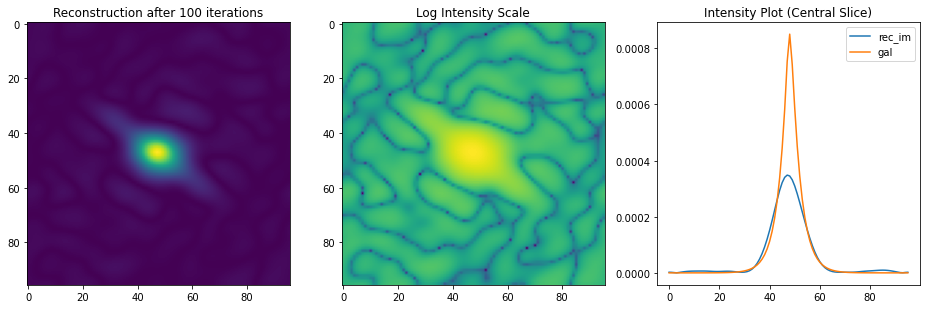

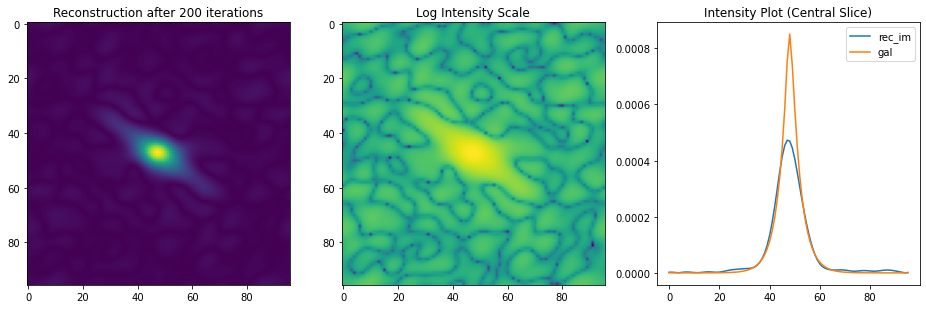

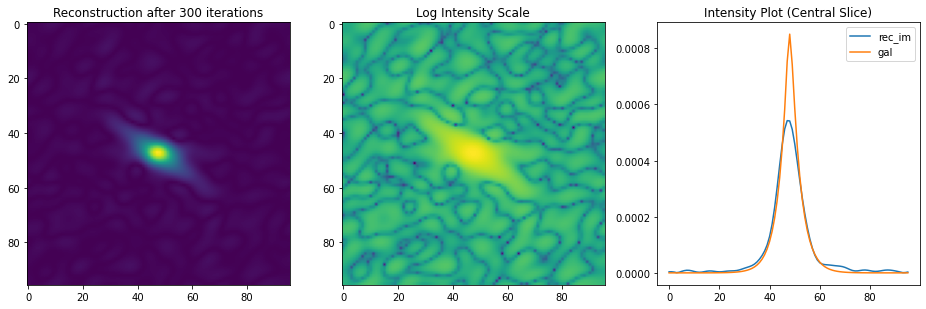

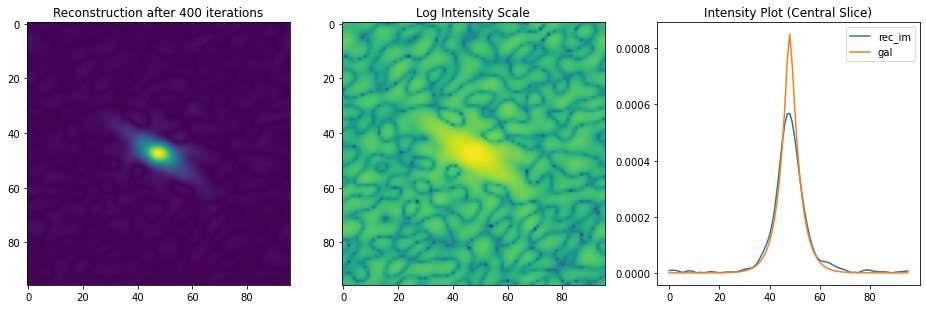

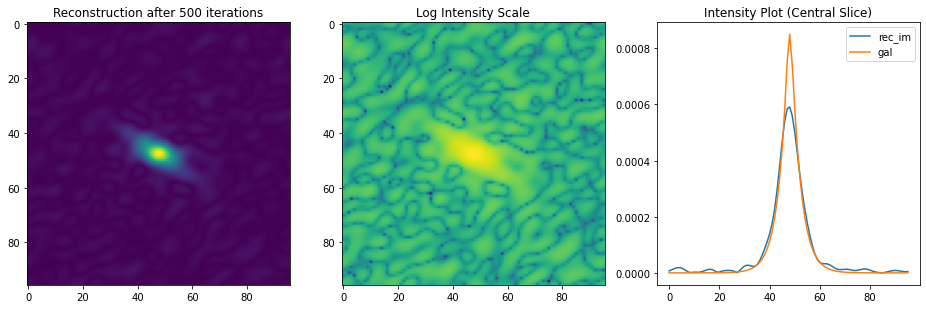

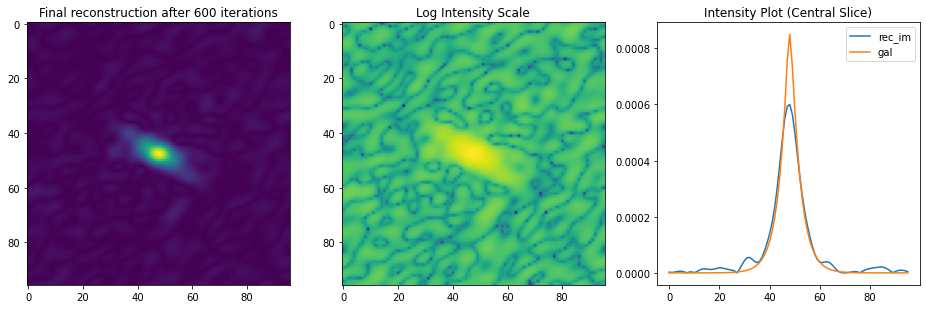

In [11]:
n_iter = 600

# ADMM parameters (initial)
z_0 = 0
mu_0 = 0
rho_0 = 50          # Augmented lagrangian hyperparameter
rho_max = 200       # max rho value
eta = 0.5           # should be between - [0, 1)
gamma = 1.4         # multiplicative rho factor -- Should be > 1
delta_0 = 0

# Deconvolve the image
final_im, x_opt, nmse_arr, cost = runADMM(final_gal, np.zeros(final_gal.shape), psf, grad, z_0, mu_0, rho_0, rho_max, 
                                          eta, gamma, delta_0, reg_lambda=1e-4, ST_lambda=1e-9, n_iter=n_iter)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
ax1.imshow(final_im); ax1.set_title('Final reconstruction after {} iterations'.format(n_iter));
ax2.imshow(np.log10(final_im)); ax2.set_title('Log Intensity Scale');

ax3.plot(final_im[48,:], label='rec_im');
ax3.plot(gal[48,:], label='gal'); 
leg = ax3.legend()
ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
plt.show(fig)

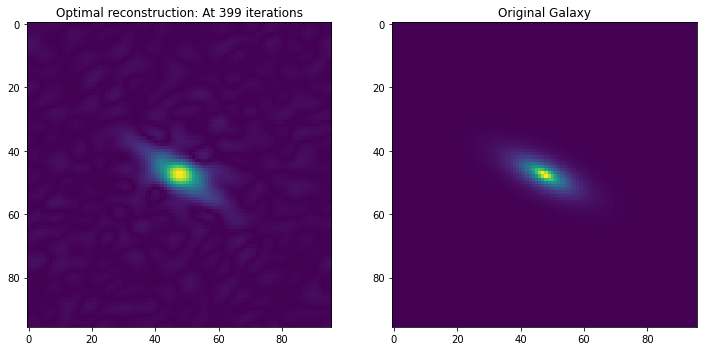

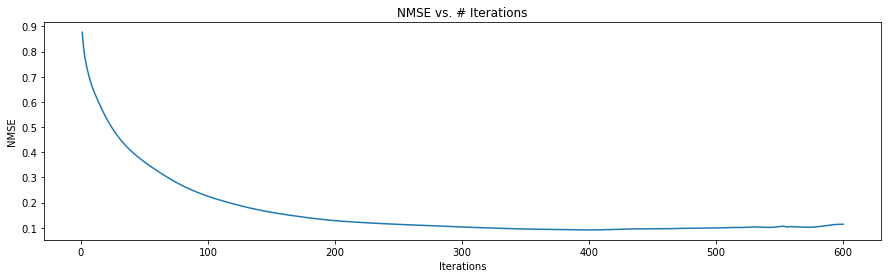


Minimum NMSE = 0.09162893548040935 (at 399 iterations)


In [12]:
# Comparison

min_nmse = np.min(nmse_arr)
min_iter = np.where(nmse_arr == min_nmse)[0][0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(x_opt); ax1.set_title('Optimal reconstruction: At {} iterations'.format(min_iter));
ax2.imshow(gal); ax2.set_title('Original Galaxy');
plt.show(fig)

fig2, ax3 = plt.subplots(1,1, figsize=(15,4))
ax3.plot(np.arange(1,n_iter+1), nmse_arr); ax3.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show(fig2)
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter))